<a href="https://colab.research.google.com/github/AMEERKOTTA/hands_on_machine_learning_with_sklearn_keras_and_tensorflow/blob/main/Intro%20to%20Tensorflow%20for%20Deep%20Learning%20/07-Time%20Series%20Forecasting/10_forecasting_using_cnn_wavenet_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **FORECASTING USING WAVENET CNN MODEL**

IMPORT LIBRARIES

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

USEFUL FUNCTIONS

In [3]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * time
  
  
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

  
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
  
  
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level
  
  
def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset
  
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

def seq2seq_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

def sequential_window_dataset(series, window_size):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds.batch(1).prefetch(1)

PREPARE THE DATASET

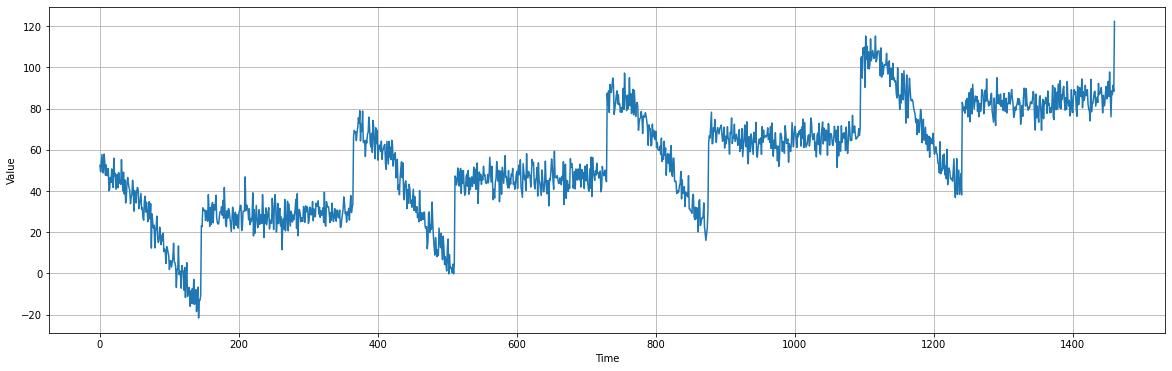

In [4]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(20, 6))
plot_series(time, series)
plt.show()

In [5]:
## split the dataset into training and validation periods
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

BUILD AND COMPILE THE 1D CONVOLUTIONAL MODEL

In [7]:
window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 14s 22ms/step - loss: 49.1284 - mae: 49.6277 - lr: 1.0000e-08
Epoch 2/100
8/8 [==============================] - 0s 11ms/step - loss: 48.8649 - mae: 49.3642 - lr: 1.1220e-08
Epoch 3/100
8/8 [==============================] - 0s 11ms/step - loss: 48.4434 - mae: 48.9428 - lr: 1.2589e-08
Epoch 4/100
8/8 [==============================] - 0s 10ms/step - loss: 47.9235 - mae: 48.4228 - lr: 1.4125e-08
Epoch 5/100
8/8 [==============================] - 0s 11ms/step - loss: 47.3277 - mae: 47.8270 - lr: 1.5849e-08
Epoch 6/100
8/8 [==============================] - 0s 10ms/step - loss: 46.6578 - mae: 47.1570 - lr: 1.7783e-08
Epoch 7/100
8/8 [==============================] - 0s 10ms/step - loss: 45.9213 - mae: 46.4204 - lr: 1.9953e-08
Epoch 8/100
8/8 [==============================] - 0s 11ms/step - loss: 45.1130 - mae: 45.6121 - lr: 2.2387e-08
Epoch 9/100
8/8 [==============================] - 0s 10ms/step - loss: 44.2182 - mae: 44.7173 - lr: 2.

(1e-08, 0.0001, 0.0, 30.0)

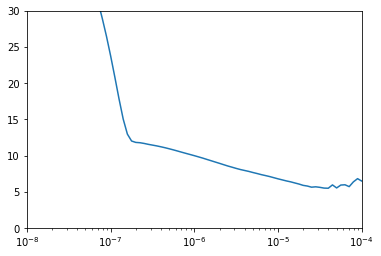

In [8]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [10]:
## using the learning rate 1e - 5.
window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200)
])
optimizer = keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
history = model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
8/8 [==============================] - 6s 166ms/step - loss: 37.4004 - mae: 37.8974 - val_loss: 34.0681 - val_mae: 34.5670
Epoch 2/500
8/8 [==============================] - 0s 27ms/step - loss: 21.5384 - mae: 22.0332 - val_loss: 25.1617 - val_mae: 25.6586
Epoch 3/500
8/8 [==============================] - 0s 25ms/step - loss: 14.9774 - mae: 15.4703 - val_loss: 25.3065 - val_mae: 25.8044
Epoch 4/500
8/8 [==============================] - 0s 37ms/step - loss: 10.6156 - mae: 11.1043 - val_loss: 15.7074 - val_mae: 16.1998
Epoch 5/500
8/8 [==============================] - 0s 34ms/step - loss: 9.1041 - mae: 9.5920 - val_loss: 16.0043 - val_mae: 16.4979
Epoch 6/500
8/8 [==============================] - 0s 27ms/step - loss: 8.0993 - mae: 8.5834 - val_loss: 13.2747 - val_mae: 13.7646
Epoch 7/500
8/8 [==============================] - 0s 33ms/step - loss: 7.4152 - mae: 7.8981 - val_loss: 14.0550 - val_mae: 14.5484
Epoch 8/500
8/8 [==============================] - 0s 30ms/step - l

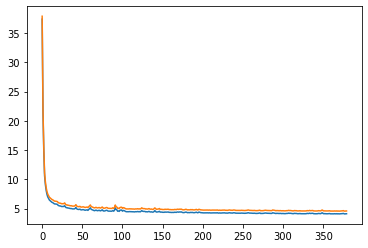

In [12]:
plt.plot(history.history["loss"], label = "Training Loss")
plt.plot(history.history["mae"], label = "Training MAE")
plt.show();

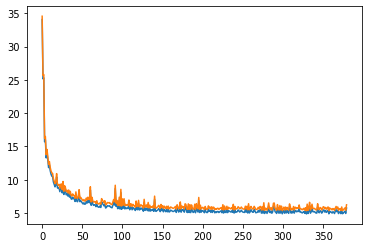

In [13]:
plt.plot(history.history["val_loss"], label = "Validation Loss")
plt.plot(history.history["val_mae"], label = "Validation MAE")
plt.show();

In [14]:
model = keras.models.load_model("my_checkpoint.h5")

In [15]:
cnn_forecast = model_forecast(model, series[:,  np.newaxis], window_size)
cnn_forecast = cnn_forecast[split_time - window_size:-1, -1, 0]

45/45 [==============================] - 2s 7ms/step


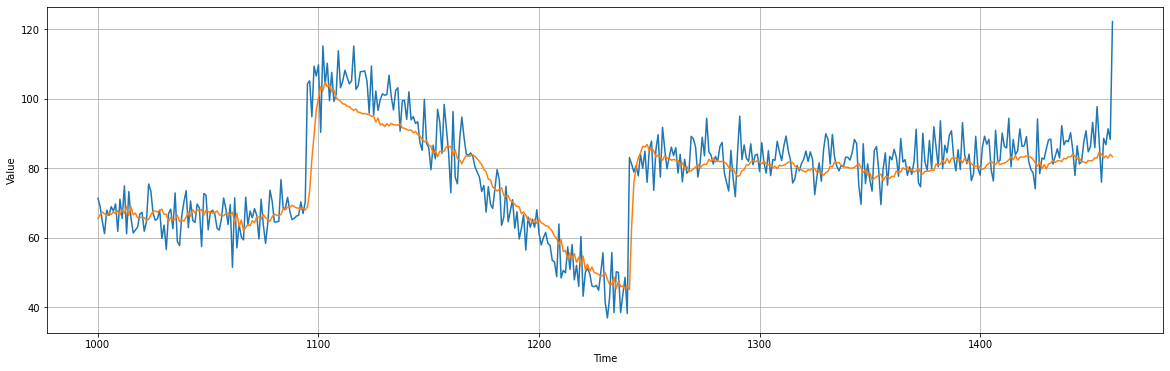

In [16]:
plt.figure(figsize=(20, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, cnn_forecast)

In [17]:
## perfomance
keras.metrics.mean_absolute_error(x_valid, cnn_forecast).numpy()

5.226146

`CNN MODEL MAE : 5.2`

FULLY CONVOLUTIONAL CNN MODEL

In [18]:
window_size = 64
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch / 30))
optimizer = keras.optimizers.Adam(learning_rate=1e-4)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 5s 45ms/step - loss: 43.1929 - mae: 43.6919 - lr: 1.0000e-04
Epoch 2/100
8/8 [==============================] - 0s 10ms/step - loss: 42.8803 - mae: 43.3792 - lr: 1.0798e-04
Epoch 3/100
8/8 [==============================] - 0s 10ms/step - loss: 42.5865 - mae: 43.0854 - lr: 1.1659e-04
Epoch 4/100
8/8 [==============================] - 0s 9ms/step - loss: 42.3174 - mae: 42.8162 - lr: 1.2589e-04
Epoch 5/100
8/8 [==============================] - 0s 9ms/step - loss: 42.0742 - mae: 42.5731 - lr: 1.3594e-04
Epoch 6/100
8/8 [==============================] - 0s 10ms/step - loss: 41.8707 - mae: 42.3697 - lr: 1.4678e-04
Epoch 7/100
8/8 [==============================] - 0s 9ms/step - loss: 41.7122 - mae: 42.2114 - lr: 1.5849e-04
Epoch 8/100
8/8 [==============================] - 0s 11ms/step - loss: 41.5490 - mae: 42.0482 - lr: 1.7113e-04
Epoch 9/100
8/8 [==============================] - 0s 10ms/step - loss: 41.3175 - mae: 41.8168 - lr: 1.8478

(0.0001, 0.1, 0.0, 30.0)

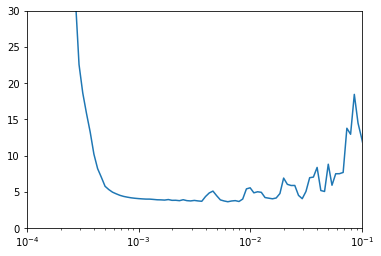

In [19]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-4, 1e-1, 0, 30])

Best Learning Rate = 3e - 4

In [20]:
window_size = 64
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
optimizer = keras.optimizers.Adam(learning_rate=3e-4)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
history = model.fit(train_set, epochs=500,
                    validation_data=valid_set,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
8/8 [==============================] - 4s 118ms/step - loss: 40.7969 - mae: 41.2957 - val_loss: 74.8936 - val_mae: 75.3936
Epoch 2/500
8/8 [==============================] - 0s 38ms/step - loss: 39.6269 - mae: 40.1257 - val_loss: 72.2237 - val_mae: 72.7237
Epoch 3/500
8/8 [==============================] - 0s 30ms/step - loss: 37.9369 - mae: 38.4355 - val_loss: 68.0295 - val_mae: 68.5295
Epoch 4/500
8/8 [==============================] - 0s 28ms/step - loss: 35.2306 - mae: 35.7292 - val_loss: 61.0360 - val_mae: 61.5360
Epoch 5/500
8/8 [==============================] - 0s 41ms/step - loss: 30.8905 - mae: 31.3886 - val_loss: 49.2868 - val_mae: 49.7859
Epoch 6/500
8/8 [==============================] - 0s 31ms/step - loss: 25.0210 - mae: 25.5173 - val_loss: 38.3250 - val_mae: 38.8233
Epoch 7/500
8/8 [==============================] - 0s 39ms/step - loss: 21.7549 - mae: 22.2504 - val_loss: 35.3261 - val_mae: 35.8238
Epoch 8/500
8/8 [==============================] - 0s 30ms/st

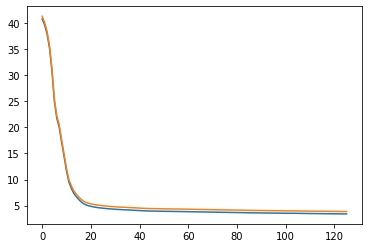

In [21]:
plt.plot(history.history["loss"], label = "Training Loss")
plt.plot(history.history["mae"], label = "Training MAE")
plt.show();

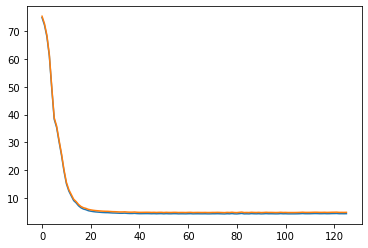

In [22]:
plt.plot(history.history["val_loss"], label = "Validation Loss")
plt.plot(history.history["val_mae"], label = "Validation MAE")
plt.show();

In [23]:
model = keras.models.load_model("my_checkpoint.h5")

In [24]:
cnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
cnn_forecast = cnn_forecast[split_time - window_size:-1, -1, 0]

44/44 [==============================] - 1s 12ms/step


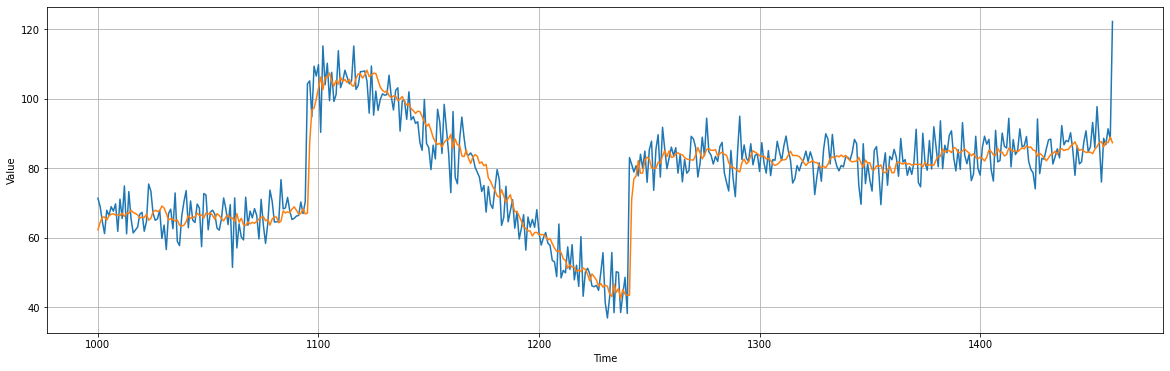

In [25]:
plt.figure(figsize=(20, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, cnn_forecast)

In [26]:
keras.metrics.mean_absolute_error(x_valid, cnn_forecast).numpy()

4.5795383

`FULLY CONVOLUTIONAL CNN MODEL MAE : 4.5`

***